# Spark
Spark is the future, and in many ways the present.  It lets us work with a lot of the concepts we've covered at scale, combining some of the best aspects of Hadoop with a smarter execution engine for problems that aren't really MapReduce. 

In this notebook we'll examine some of the primitives that Spark has for transforming data in a distributed fashion, as well as use MLLib to implement machine learning in Spark.

## PySpark
PySpark is the Python binding for Spark, so that's how we'll investigate Spark in this notebook.  To get it up and running, you'll have to go through some gymnastics like the next few cells.

### Using Python 3 in this notebook (make sure kernel matches)

In [27]:
!python --version

Python 3.5.2 :: Continuum Analytics, Inc.


In [57]:
import os

In [62]:
# this might give you an error
#import findspark

In [61]:
# install findspark
!pip install findspark

In [64]:
# Finds the location of spark installation
import findspark
findspark.init()

In [58]:
# to see which packages, libraries are installed
#!pip freeze

##### A spark context is the main entry point for Spark functionality. It is the connection to the Spark cluster and can be used to creat RDDs, accumulators and broadcast variables on that cluster

In [1]:
# Fire up a Spark context
import pyspark
sc = pyspark.SparkContext()
sc

In [31]:
spark_home = os.environ.get('SPARK_HOME', None)

In [32]:
print (spark_home)

/usr/local/spark


In [33]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from StringIO import StringIO
from datetime import datetime
from collections import namedtuple
from operator import add, itemgetter
from sklearn.linear_model import SGDClassifier
import csv
from pyspark import SparkConf, SparkContext
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint

### The Word Count Example
Now that we have PySpark up and running, let's try out the canonical word count example.

In [34]:
# Read in the course README file with a simple call to textFile
text_file = sc.textFile("0_spark_about.md")

In [35]:
type(text_file)

pyspark.rdd.RDD

In [36]:
text_file.take(10)

['',
 '# SPARK',
 '',
 "Spark is the future, Spark is right now.  The goal is essentially an end-to-end platform for data science on Big Data, the way sklearn is for small data.  It's not there yet, but it's growing daily.",
 '',
 '## WHAT IS Spark?',
 '',
 '\t* Spark is a fast and general engine for large-scale distributed data processing.',
 '\t* Spark can run programs up to 100x faster than Hadoop MapReduce in memory, or 10x faster on disk.',
 "\t* Spark improves on MapReduce's computation model with an advanced DAG (Directed Acyclic Graph) execution engine that supports cyclic data flow and in-memory computing."]

##### RDD = Resilient Distributed Dataset. This is an immutable, partitioned collection of elements that can be operated upon in parallel
Let's do some word counting on this RDD.

##### We can apply a filter using an anonymous function

In [37]:
lines_not_empty = text_file.filter(lambda x: len(x) > 0)

In [38]:
lines_not_empty.count()

53

In [39]:
text_file.count()

78

##### We can use the `take()` function to retrieve items from our RDDs

In [40]:
lines_not_empty.take(10)

['# SPARK',
 "Spark is the future, Spark is right now.  The goal is essentially an end-to-end platform for data science on Big Data, the way sklearn is for small data.  It's not there yet, but it's growing daily.",
 '## WHAT IS Spark?',
 '\t* Spark is a fast and general engine for large-scale distributed data processing.',
 '\t* Spark can run programs up to 100x faster than Hadoop MapReduce in memory, or 10x faster on disk.',
 "\t* Spark improves on MapReduce's computation model with an advanced DAG (Directed Acyclic Graph) execution engine that supports cyclic data flow and in-memory computing.",
 '\t* Spark runs on Hadoop, Mesos, standalone, or in the cloud. It can access diverse data sources including HDFS, Cassandra, HBase, and S3.',
 '\t* Spark is written in Scala, but has bindings for Java, Python (PySpark), and R',
 '\t',
 '### Spark Modules']

##### flatMap() 
- flattens the return lists into a single list

In [41]:
words = text_file.flatMap(lambda x: x.split())

In [42]:
words.take(100)

['#',
 'SPARK',
 'Spark',
 'is',
 'the',
 'future,',
 'Spark',
 'is',
 'right',
 'now.',
 'The',
 'goal',
 'is',
 'essentially',
 'an',
 'end-to-end',
 'platform',
 'for',
 'data',
 'science',
 'on',
 'Big',
 'Data,',
 'the',
 'way',
 'sklearn',
 'is',
 'for',
 'small',
 'data.',
 "It's",
 'not',
 'there',
 'yet,',
 'but',
 "it's",
 'growing',
 'daily.',
 '##',
 'WHAT',
 'IS',
 'Spark?',
 '*',
 'Spark',
 'is',
 'a',
 'fast',
 'and',
 'general',
 'engine',
 'for',
 'large-scale',
 'distributed',
 'data',
 'processing.',
 '*',
 'Spark',
 'can',
 'run',
 'programs',
 'up',
 'to',
 '100x',
 'faster',
 'than',
 'Hadoop',
 'MapReduce',
 'in',
 'memory,',
 'or',
 '10x',
 'faster',
 'on',
 'disk.',
 '*',
 'Spark',
 'improves',
 'on',
 "MapReduce's",
 'computation',
 'model',
 'with',
 'an',
 'advanced',
 'DAG',
 '(Directed',
 'Acyclic',
 'Graph)',
 'execution',
 'engine',
 'that',
 'supports',
 'cyclic',
 'data',
 'flow',
 'and',
 'in-memory',
 'computing.',
 '*',
 'Spark']

##### The map function
- map returns a new RDD containing values created by applying the supplied lambda function to each value in the original RDD
- A map function utlizing the anonymous Python function lambda

In [43]:
words = words.map(lambda x: x.replace('|', '').replace('.', '').\
                  replace('-', '').replace(' ', '').replace('&', '').replace('#','').upper())

In [44]:
words.take(10)

['', 'SPARK', 'SPARK', 'IS', 'THE', 'FUTURE,', 'SPARK', 'IS', 'RIGHT', 'NOW']

We have some ugly characters in there.  Let's create a filter that filters out all tokens that doesn't have at least one letter:

In [45]:
import re
words = words.filter(lambda x: re.match('[A-Z]+', x))

In [46]:
words.subtract(sc.parallelize(['IS', 'WHAT'])).take(10)

['FAULTTOLERANT',
 'SC',
 'SC',
 'ASSIGNED',
 'LAUNCHES',
 'THAT',
 'THAT',
 'THAT',
 'THAT',
 'THAT']

In [47]:
words.take(10)

['SPARK',
 'SPARK',
 'IS',
 'THE',
 'FUTURE,',
 'SPARK',
 'IS',
 'RIGHT',
 'NOW',
 'THE']

##### A word counting mapper function

In [48]:
word_counts = words.map(lambda x: (x, 1))

In [49]:
word_counts.take(10)

[('SPARK', 1),
 ('SPARK', 1),
 ('IS', 1),
 ('THE', 1),
 ('FUTURE,', 1),
 ('SPARK', 1),
 ('IS', 1),
 ('RIGHT', 1),
 ('NOW', 1),
 ('THE', 1)]

##### Now do a reduction
##### The reduceByKey function
- input must be tuples of the form (key, value)
- creates a new RDD containing a tuple for each unique value of the key
- the value in the output depends upon the supplied lambda function

In [50]:
word_counts = word_counts.reduceByKey(lambda a, b: a + b)

In [51]:
word_counts.take(10)

[('FAULTTOLERANT', 1),
 ('DATAFRAMES', 1),
 ('LAUNCHES', 1),
 ('BE', 6),
 ('THAT', 9),
 ('SERIALIZABLE', 1),
 ('WHERE', 2),
 ('LIKE', 1),
 ('COLLECTION', 2),
 ('PROVIDES', 1)]

##### Now do another map and swap the key and the value in terms of their positions
##### Which will make the value the key

In [52]:
word_counts = word_counts.map(lambda x: (x[1], x[0]))

In [53]:
word_counts = word_counts.sortByKey(False)

In [54]:
word_counts.take(10)

[(28, 'SPARK'),
 (21, 'THE'),
 (18, 'IS'),
 (14, 'IN'),
 (13, 'FOR'),
 (13, 'DATA'),
 (11, 'TO'),
 (11, 'ON'),
 (10, 'A'),
 (9, 'THAT')]

### A Second Word Count Example

In [55]:
lines = sc.parallelize(['Its fun to have fun,','but you have to know how.']) 

In [67]:
lines.mapPartitionsWithIndex
lines.mapPartitionsWithSplit

<bound method RDD.mapPartitionsWithSplit of ParallelCollectionRDD[40] at parallelize at PythonRDD.scala:423>

In [68]:
rd1 = lines.map(lambda x: x.replace('|', '').\
                replace('.', '').replace('-', '').replace('&', '').replace('#','').upper())

In [69]:
rd1.take(10)

['ITS FUN TO HAVE FUN,', 'BUT YOU HAVE TO KNOW HOW']

In [70]:
rd2 = rd1.flatMap(lambda x: x.split())

In [71]:
rd2.take(20)

['ITS', 'FUN', 'TO', 'HAVE', 'FUN,', 'BUT', 'YOU', 'HAVE', 'TO', 'KNOW', 'HOW']

In [72]:
#create the tuples required for the reduce step, 1 is the value and this will be counted by the reduce lamda function
rd3 = rd2.map(lambda x: (x, 1))

In [73]:
rd4 = rd3.reduceByKey(lambda a, b: a + b)

In [74]:
rd4.take(20)

[('BUT', 1),
 ('TO', 2),
 ('HOW', 1),
 ('YOU', 1),
 ('ITS', 1),
 ('FUN,', 1),
 ('KNOW', 1),
 ('FUN', 1),
 ('HAVE', 2)]

In [75]:
#use another map function to swap the key, value positionally
rd5 = rd4.map(lambda x: (x[1], x[0]))

In [76]:
rd5.take(20)

[(1, 'BUT'),
 (2, 'TO'),
 (1, 'HOW'),
 (1, 'YOU'),
 (1, 'ITS'),
 (1, 'FUN,'),
 (1, 'KNOW'),
 (1, 'FUN'),
 (2, 'HAVE')]

##### The function sortByKey does exactly what is says, and sorts the tuples using the key value

In [77]:
rd6 = rd5.sortByKey(ascending=False)

In [78]:
rd6.take(20)

[(2, 'TO'),
 (2, 'HAVE'),
 (1, 'BUT'),
 (1, 'HOW'),
 (1, 'YOU'),
 (1, 'ITS'),
 (1, 'FUN,'),
 (1, 'KNOW'),
 (1, 'FUN')]

### Working a slightly more complicated example

##### Let's use the 20 news groups dataset

In [79]:
ngd = fetch_20newsgroups(shuffle = True, remove = ("headers", "footers", "quotes"), random_state = 6)

##### Create an RDD

In [80]:
mrd1 = sc.parallelize(ngd.data) 

In [81]:
print np.shape(ngd.data)
print type(mrd1)

SyntaxError: invalid syntax (<ipython-input-81-6af5bdb72207>, line 1)

In [ ]:
mrd1.take(2)

##### `glom()` allows you to treat a partition as an array rather than as a single row at a time

In [ ]:
test = mrd1.glom()

In [ ]:
#test.take(1)

#### Chaining commands
##### The aim here is to get a list of sentences
1. Use `glom()` to convert the partitions to an array of documents
2. Use `map()` to join the array of documents into 1 massive string with documents separated by a space
3. Use `flatMap()` to split the massive string by sentence into an array of sentences
4. Use `map()` to replace all newlines with '' and make everything lowercase
5. Use `map()` to remove all occurrences of "the"

In [ ]:
mrd2 = mrd1.glom().map(lambda x: " ".join(x)).flatMap(lambda x: x.split('.')).map(lambda x: x.replace('\n', '').\
    lower()).map(lambda x: x.replace(' the ', ' '))

In [ ]:
mrd2.take(2)

#### Exercise: Using the sentences write a mapping function to find all the bigrams
- Use a `map()` that splits the sentences (x) into a list of tokens via the `split()` function
- Use a `flatMap()` that loops through each list and returns something like `((x[i], x[i+1]), 1)` for all the tokens in `x`

In [ ]:
bigrams = mrd2.map(lambda x: x.split()).flatMap(lambda x: [((x[i], x[i+1]), 1) for i in range(len(x)-1)]).reduceByKey(lambda a, b: a+b)

In [ ]:
#Check out the first 10 bigrams with take()
bigrams.takeOrdered(10, key=(lambda x: -x[1]))

##### Now let's count up the number of occurrences for each bigram
- Use a `reduceByKey()` to sum up the occurrences
- Use a `map()` to exchange the resulting keys with values
- Use a `sortByKey()` to sort the results in descending order

##### Use a `take()` to print out the top 10 bigrams!!

#### Spark supports the efficient parallel application of map and reduce operations by dividing data up into multiple partitions.
- Each partition is replicated across multiple workers running on different nodes in a cluster so that failure of a single worker should not cause the RDD to become unavailable.
- Many operations including map and flatMap can be applied independently to each partition, running as concurrent jobs based on the number of available cores. 
- When processing reduceByKey, Spark will create a number of output partitions based on the *default* paralellism based on the numbers of nodes and cores available to Spark. 
- Data is effectively reshuffled so that input data from different input partitions with the same key value is passed to the same output partition and combined there using the specified reduce function. 
- sortByKey is another operation which transforms N input partitions to M output partitions.
- The number of partitions generated by the reduce stage can be controlled by supplying the desired number of partitions as an extra parameter to reduceByKey

In [82]:

sc.defaultParallelism

2

In [83]:
new1 = sc.parallelize(ngd.data).glom().map(lambda x: " ".join(x)).flatMap(lambda x: x.split('.')).\
    map(lambda x: x.replace('\n', '').lower()).map(lambda x: x.replace('the', '')).map(lambda x: x.split()).\
    flatMap(lambda x: [((x[i], x[i+1]), 1) for i in range(0, len(x)-1)]).\
    reduceByKey(lambda a, b: a + b, numPartitions = 12).\
    map(lambda x: (x[1], x[0])).sortByKey(False)

In [84]:
def countPartitions(id, iterator): 
    c = 0 
    for _ in iterator: 
        c += 1 
        yield (id, c) 

In [85]:
new1.mapPartitionsWithIndex(countPartitions).collectAsMap()

{0: 39666, 1: 43980, 2: 90094, 11: 706648}

In [86]:
new1.take(10)

[(2954, ('to', 'be')),
 (2895, ('it', 'is')),
 (2508, ('is', 'a')),
 (2178, ('i', 'have')),
 (2170, ('if', 'you')),
 (1854, ('this', 'is')),
 (1591, ('of', 'a')),
 (1531, ('in', 'a')),
 (1529, ('i', 'am')),
 (1496, ('is', 'not'))]

### A Numerical Example
Let's use Spark to find all the primes in any range we specify.  Here's a function that determines if a number is prime:

In [87]:
def isprime(n):
    """
    check if integer n is a prime
    """
    
    # make sure n is a positive integer
    n = abs(int(n))
    
    # 0 and 1 are not primes
    if n < 2:
        return False
    
    # 2 is the only even prime number
    if n == 2:
        return True
    
    # all other even numbers are not primes
    if not n & 1:
        return False
    
    # range starts with 3 and only needs to go up the square root of n
    # for all odd numbers
    for x in range(3, int(n**0.5)+1, 2):
        if n % x == 0:
            return False
    return True

In [89]:
# Create an RDD of numbers from 0 to 1,000,000
nums = sc.parallelize(xrange(1000000))

nums.take(10)

NameError: name 'xrange' is not defined

The `filter()` function allows us to supply a function that returns a boolean and filter an `RDD` by those entries that return True for that function.  Here's how we would use it to return prime numbers less than 1 million.

In [ ]:
primes = nums.filter(isprime)

In [137]:
primes.take(10)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

In [138]:
# Compute the number of primes in the RDD
print primes.count()

78498


### Airline Delay Example

[Modified from "Getting Started with Spark (in Python) by Benjamin  Bengfort](https://districtdatalabs.silvrback.com/getting-started-with-spark-in-python)

##### Setup some definitions and declarations

In [56]:
fields   = ('date', 'airline', 'flightnum', 'origin', 'dest', 'dep',
            'dep_delay', 'arv', 'arv_delay', 'airtime', 'distance')
Flight   = namedtuple('Flight', fields)
DATE_FMT = "%Y-%m-%d"
TIME_FMT = "%H%M"

##### Ref: the use of named tuples
[Named tuples](http://pymotw.com/2/collections/namedtuple.html)

##### Function to parse a row of the database and fill a row of a named tuple

In [179]:
def parse(row):
    '''Parses a row and returns a named tuple'''

    row[0]  = datetime.strptime(row[0], DATE_FMT).date()
    row[5]  = datetime.strptime(row[5], TIME_FMT).time()
    row[6]  = float(row[6])
    row[7]  = datetime.strptime(row[7], TIME_FMT).time()
    row[8]  = float(row[8])
    row[9]  = float(row[9])
    row[10] = float(row[10])
    
    #function returns a completed named tuple constructed from a row
    return Flight(*row[:11])

##### Uses line as if it were a file (StringIO)
##### csv.reader breaks it into lines

In [180]:
def split(line):
    '''Operator function for splitting a line with csv module'''
    
    reader = csv.reader(StringIO(line))
    return reader.next()

##### The use of the broadcast function

In [181]:
#this is an airlines lookup dictionary
airlines = dict(sc.textFile("data/airlines.csv").map(split).collect())

print type(airlines)

for i, key in enumerate(airlines.keys()):
    print key, airlines[key]
    if i == 5:
        break

<type 'dict'>
19719 Coastal Air Transport: CTL
19718 Cresent Medivac: CRH
19713 Alliance Airlines: ACN
19712 Business Express Airlines: BEA
19711 Eagle Airline: EGA
19710 Armstrong Air Service Inc.: AAP


##### The airline lookup converts airline index to airline string

In [182]:
#broadcast the dictionary to the cluster
airline_lookup = sc.broadcast(airlines)

type(airline_lookup)

pyspark.broadcast.Broadcast

##### Eyeball the data in regular Python

In [183]:
df = pd.read_csv("data/flights.csv")
df.columns = fields
df.head(2)

date  airline  flightnum origin dest   dep  dep_delay   arv  \
0  2014-04-01    19805          2    LAX  JFK   944         14  1736   
1  2014-04-01    19805          3    JFK  LAX  1224         -6  1614   

   arv_delay  airtime  distance  
0        -29      269      2475  
1         39      371      2475

In [184]:
#load the flights data into an RDD
#transfer a row of the data into the named tuple, and then split it on the fields of the tuple
flights = sc.textFile("data/flights.csv").map(split).map(parse)

print type(flights)

flights.take(1)

<class 'pyspark.rdd.PipelinedRDD'>


[Flight(date=datetime.date(2014, 4, 1), airline='19805', flightnum='1', origin='JFK', dest='LAX', dep=datetime.time(8, 54), dep_delay=-6.0, arv=datetime.time(12, 17), arv_delay=2.0, airtime=355.0, distance=2475.0)]

##### Here's the named tuple in use

In [185]:
tt = flights.take(1)[0]
print tt.date
print tt.airline
print tt.flightnum
print tt.origin
print tt.dest
print tt.dep_delay
print tt.arv_delay

2014-04-01
19805
1
JFK
LAX
-6.0
2.0


##### and the airline lookup

In [186]:
airline_lookup.value['19805']

'American Airlines Inc.: AA'

##### map the delays into a key value pair

In [187]:
#map the total delay to the airline, joined using the broadcast value
delays = flights.map(lambda f: (airline_lookup.value[f.airline], add(f.dep_delay, f.arv_delay)))

In [188]:
print type(delays)
delays.take(1)

<class 'pyspark.rdd.PipelinedRDD'>


[('American Airlines Inc.: AA', -4.0)]

##### Sum up the delays

In [189]:
#reduce to the total delay for the month
delays = delays.reduceByKey(add).collect()

print type(delays)
print delays[0]

<type 'list'>
('Envoy Air: MQ', 493527.0)


In [190]:
#and sort the list
delays = sorted(delays, key=itemgetter(1))

In [191]:
print delays[0]

('Alaska Airlines Inc.: AS', -45442.0)


##### This is a list of airlines by increasing delay times

In [192]:
print "{:43s} {:15s}".format("Airline", "Delay (mins)")
for d in delays:
    print "{:35s} {:15.0f}".format(d[0], d[1])

Airline                                     Delay (mins)   
Alaska Airlines Inc.: AS                     -45442
Hawaiian Airlines Inc.: HA                   -20654
AirTran Airways Corporation: FL               39247
Virgin America: VX                            40841
Frontier Airlines Inc.: F9                   108480
US Airways Inc.: US                          177717
JetBlue Airways: B6                          279981
United Air Lines Inc.: UA                    390614
American Airlines Inc.: AA                   431755
Delta Air Lines Inc.: DL                     461753
Envoy Air: MQ                                493527
SkyWest Airlines Inc.: OO                    519867
ExpressJet Airlines Inc.: EV                1160058
Southwest Airlines Co.: WN                  2181955


##### and a plot of same

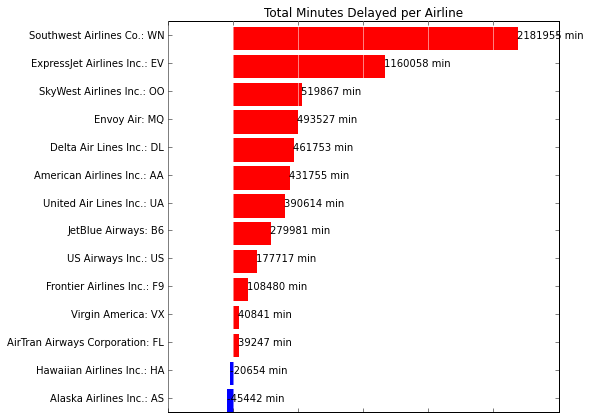

In [193]:
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(111)


airlines = [d[0] for d in delays]
minutes = [d[1] for d in delays]
index = list(xrange(len(airlines)))

bars = ax.barh(index, minutes)

for idx, air, mins in zip(index, airlines, minutes):
    if mins > 0:
        bars[idx].set_color("red")
        ax.annotate("{:0.0f} min".format(mins), xy=(mins+1, idx+0.5), va='center')
    else:
        bars[idx].set_color("blue")
        ax.annotate("{:0.0f} min".format(mins), xy=(mins+1, idx+0.5), va='center')
        
ax.set_yticks([idx + 0.5 for idx in index])
ax.set_yticklabels(airlines)
xt = ax.get_xticks()
ax.set_xticklabels([' ']*len(xt))
ax.grid(axis='x', color='white', linestyle='-')
ax.set_title("Total Minutes Delayed per Airline")

## Logistic Regression with Spark MLlib
MLlib is how Spark does Machine Learning.  It has a variety of (what should be!) familiar algorithms that are optimized to work in a distributed fashion!

### Python First

In [71]:
dat = pd.read_csv("data/sample_svm_data.txt", delimiter = ' ', header = None)

In [72]:
dat.head(1)

0   1         2   3   4   5         6         7   8         9         10  \
0   1   0  2.520784   0   0   0  2.004684  2.000347   0  2.228387  2.228387   

   11  12  13  14  15  16  
0   0   0   0   0   0   0

In [73]:
predictors = dat.columns.values[1:]
print predictors

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [74]:
X = dat[predictors]
y = dat[0]

In [75]:
clf_pySGD = SGDClassifier(loss='log', alpha = 0.01, n_iter = 10000)
clf_pySGD.fit(X, y)
yhat = clf_pySGD.predict(X)
print clf_pySGD.score(X, y)

0.636645962733


In [76]:
cm = pd.crosstab(y, yhat, rownames=["Actual"], colnames=["Predicted"])
cm

Predicted    0    1
Actual             
0          101   59
1           58  104

### Spark

##### LabeledPoint is a built in Pyspark class (label, features)

In [77]:
def parse_point(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

In [78]:
data = sc.textFile("data/sample_svm_data.txt")

In [79]:
data.take(1)

[u'1 0 2.52078447201548 0 0 0 2.004684436494304 2.000347299268466 0 2.228387042742021 2.228387042742023 0 0 0 0 0 0']

##### Map into key value pairs

In [80]:
parsed_data = data.map(parse_point)

In [81]:
print type(parsed_data)
parsed_data.first()

<class 'pyspark.rdd.PipelinedRDD'>


LabeledPoint(1.0, [0.0,2.52078447202,0.0,0.0,0.0,2.00468443649,2.00034729927,0.0,2.22838704274,2.22838704274,0.0,0.0,0.0,0.0,0.0,0.0])

###### Use the Spark logisitic regression model

In [82]:
spark_clf = LogisticRegressionWithSGD.train(parsed_data)

print type(spark_clf)

<class 'pyspark.mllib.classification.LogisticRegressionModel'>


##### p is a labelled point

In [83]:
labels_and_predictions = parsed_data.map(lambda p: (p.label, spark_clf.predict(p.features)))

In [84]:
print type(labels_and_predictions)
print labels_and_predictions.take(10)

<class 'pyspark.rdd.PipelinedRDD'>
[(1.0, 1), (0.0, 1), (0.0, 0), (1.0, 1), (1.0, 0), (0.0, 1), (1.0, 1), (1.0, 1), (0.0, 0), (0.0, 0)]


In [85]:
print parsed_data.count()

322


In [87]:
yyhat = labels_and_predictions.reduceByKey(lambda x, y: x + y).collect()
yyhat

[(0.0, 59), (1.0, 104)]

In [209]:
yyhat = labels_and_predictions.reduceByKey(lambda x, y: x + y).collect()
landp = labels_and_predictions.map(lambda x : (x[1], x[0]))
yyhat_1 = landp.reduceByKey(lambda x, y: x + y).collect()


print yyhat
print yyhat_1
print labels_and_predictions.filter(lambda (x, y): x != y).count()
print labels_and_predictions.filter(lambda (x, y): x == y).count()

[(0.0, 59), (1.0, 104)]
[(0, 58.0), (1, 104.0)]
117
205


In [210]:
results = list(labels_and_predictions.take(1000))
y = np.array([x[0] for x in results])
yhat = np.array([x[1] for x in results])

In [211]:
cm = pd.crosstab(y, yhat, rownames=["Actual"], colnames=["Predicted"])
cm

Predicted    0    1
Actual             
0          101   59
1           58  104

In [90]:
training_error = labels_and_predictions.filter(lambda (v, p): v != p).count()/float(parsed_data.count())

In [91]:
print training_error

0.363354037267


### On Your Own
Go back to any of your favorite classification datasets that we've dealt with and see if you can implement the classifier with Spark as we just did above.